# Computer Vision with PyTorch

In this notebook, we will work through a computer vision problem using PyTorch.  
The workflow will be as follows:

1. **Dataset Setup**  
   - Begin with the **CIFAR-10** dataset from **torchvision** as our practice dataset.  
   - Download the dataset and visualize a few sample images.  

2. **Data Preparation**  
   - Build data loaders for both the training and test sets.  

3. **Baseline Model**  
   - Implement our first non-linear model.  
   - Evaluate its performance using a **loss function** and **accuracy** metrics.  

3. **Improved Basedline Model**
   - Perform following improvements on the base line model -
         1. Normalize the input - Based on the mean and standard deviation of each channel, normalize the input.
         2. Data Agumentation - Augment the training data by doing rotation / padding etc so that models can learn better.
         3. DropOut layer - During training, dropout some section of neurons so that each neuron can learn independently.
         4. Adaptive Learning Rate - Instead of a static learning rate, we will adopt faster learning rate at the start and slow down as we progress.

   - Evaluate its performance using a **loss function** and **accuracy** metrics. 

4. **CNN Model**  
   - Develop a **Convolutional Neural Network (CNN)** model.  
   - Re-evaluate performance using the same metrics (loss and accuracy).  

5. **Predictions & Analysis**  
   - Generate predictions on the test set.  
   - Plot a **confusion matrix** to analyze how well the model performs across classes.  


In [376]:
# Importing necessary packages

import torch

from torch import nn

import torchvision

from torchvision import datasets

from torchvision import transforms

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


print(torch.__version__)
print(torchvision.__version__)

2.8.0
0.23.0


In [ ]:
## Dataset Setup

# Download the CIFAR10 dataset
train_data = datasets.CIFAR10(root="data",train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_data = datasets.CIFAR10(root="data",train=False,transform=torchvision.transforms.ToTensor(),download=True)


print(f"Length of training data - {len(train_data)}")
print(f"Length of test data : {len(test_data)}")

Length of training data - 50000
Length of test data : 10000


 Image shape : torch.Size([3, 32, 32])
Label  : 6
Available labels : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Label to index mapping : {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


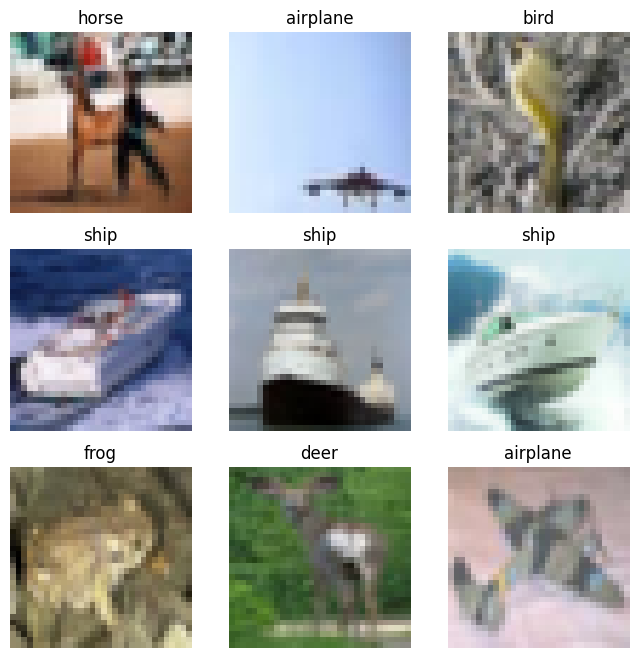

In [ ]:
# Getting used to the data

image, label = train_data[0]

print(f" Image shape : {image.shape}")
print(f"Label  : {label}")
print(f"Available labels : {train_data.classes}")
print(f"Label to index mapping : {train_data.class_to_idx}")

#Visualizing few of the training images
rows,cols = 3,3
fig = plt.figure(figsize=(8,8))

for i in range(1,(rows*cols)+1):
    inx = torch.randint(0,len(train_data),size=[1]).item()
    image,label = train_data[inx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(image.permute(1,2,0))
    plt.title(train_data.classes[label])
    plt.axis(False)


In [379]:
## Data Preparation

from torch.utils.data import DataLoader

BATCH_SIZE=32

train_data_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

print(f"DataLoaders : {train_data_loader}{test_data_loader}\n")
print(f"Shape of Train Dataloader : {len(train_data_loader)}")
print(f"Shape of Test Dataloader :  {len(test_data_loader)}")
print(f"Batch Size : {BATCH_SIZE}")

DataLoaders : <torch.utils.data.dataloader.DataLoader object at 0x37ec3cf50><torch.utils.data.dataloader.DataLoader object at 0x346863390>

Shape of Train Dataloader : 1563
Shape of Test Dataloader :  313
Batch Size : 32


In [ ]:
# Checking the shape one sample batch 

batch_train_features, batch_train_labels = next(iter(test_data_loader))

print(batch_train_features.shape,batch_train_labels.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32])


In [381]:
import requests

from pathlib import Path

if Path("helper_functions.py").is_file():
    print("Helper function file already exists")
else:
    print("Downloading the helper function")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/af6548e52663c8395fe2777bd0fbfd6ac85fd6f8/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)


# Create a function to time our experiments
# Two of the main things you will often want to track are:
# 1. Model's performance (loss and accuracy values)
# 2. How fast it runs


from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
  """Print difference between start and end time. """
  total_time = end - start
  print(f" Train time on {device} : {total_time:.3f} second")
  return total_time

Helper function file already exists


In [382]:
#Defining a simple non-linear model
import torch.nn
class CFIR_V0(nn.Module):
    def __init__(self,input_shape:int, output_shape:int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self,x):
        return self.layer_stack(x)

model_0 = CFIR_V0(input_shape=3072,output_shape=len(train_data.classes),hidden_units=8)
model_0


CFIR_V0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=8, bias=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=10, bias=True)
  )
)

In [ ]:
# Defining Loss and Optimizer Function

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

#Device agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"


#Defining methods for train and test process

def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,accuracy_fn,optimizer: torch.optim.Optimizer,device:torch.device=device,print_details=False):
    
    train_loss,train_acc = 0,0

    model.to(device)
    model.train()

    for batch, (X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if print_details:
        print(f"Train Loss - {train_loss:.5f} | Train accuracy - {train_acc:.2f}%")

def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,accuracy_fn,device:torch.device=device,print_details=False):
    
    test_loss,test_acc = 0,0

    model.to(device)
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss
            test_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    if print_details:

        print(f"Test Loss - {test_loss:.5f} | Test accuracy - {test_acc:.2f}%")

    


In [ ]:

#Training the first model
torch.manual_seed(42)

from timeit import default_timer as timer 
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

train_time_start = timer()

epochs = 10

for epoch in  tqdm(range(epochs)):
    print(f"Epoch - {epoch}\n-----")
    print_details = True
    train_step(model_0,train_data_loader,loss_fn,accuracy_fn,optimizer,device,print_details)
    test_step(model_0,test_data_loader,loss_fn,accuracy_fn,device,print_details)
train_time_end = timer()
total_train_time = print_train_time(train_time_start,train_time_end,device)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch - 0
-----
Train Loss - 2.17801 | Train accuracy - 15.93%


 10%|█         | 1/10 [00:02<00:18,  2.06s/it]

Test Loss - 2.15249 | Test accuracy - 17.98%
Epoch - 1
-----
Train Loss - 2.15843 | Train accuracy - 16.56%


 20%|██        | 2/10 [00:04<00:16,  2.09s/it]

Test Loss - 2.13388 | Test accuracy - 16.31%
Epoch - 2
-----
Train Loss - 2.15115 | Train accuracy - 16.71%


 30%|███       | 3/10 [00:06<00:14,  2.06s/it]

Test Loss - 2.13000 | Test accuracy - 18.77%
Epoch - 3
-----
Train Loss - 2.15258 | Train accuracy - 16.46%


 40%|████      | 4/10 [00:08<00:12,  2.04s/it]

Test Loss - 2.25978 | Test accuracy - 14.15%
Epoch - 4
-----
Train Loss - 2.14828 | Train accuracy - 16.56%


 50%|█████     | 5/10 [00:10<00:10,  2.05s/it]

Test Loss - 2.16400 | Test accuracy - 18.36%
Epoch - 5
-----
Train Loss - 2.14892 | Train accuracy - 16.62%


 60%|██████    | 6/10 [00:12<00:08,  2.04s/it]

Test Loss - 2.09293 | Test accuracy - 17.64%
Epoch - 6
-----
Train Loss - 2.14422 | Train accuracy - 16.80%


 70%|███████   | 7/10 [00:14<00:06,  2.03s/it]

Test Loss - 2.15720 | Test accuracy - 16.16%
Epoch - 7
-----
Train Loss - 2.15052 | Train accuracy - 16.69%


 80%|████████  | 8/10 [00:16<00:04,  2.02s/it]

Test Loss - 2.08520 | Test accuracy - 18.82%
Epoch - 8
-----
Train Loss - 2.14284 | Train accuracy - 16.84%


 90%|█████████ | 9/10 [00:18<00:02,  2.01s/it]

Test Loss - 2.14427 | Test accuracy - 16.24%
Epoch - 9
-----
Train Loss - 2.13776 | Train accuracy - 16.78%


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

Test Loss - 2.28309 | Test accuracy - 12.93%
 Train time on cpu : 20.309 second


## Defining second non-linear model with some improvements
1. Normalizing the channel inputs based on the mean and standard deviation.
2. Data Augmentation - Make some minor augmentation on training data like rotation/padding etc to make model training more robust.
3. Regularization - Dropping out certain percentage of neurons while training during each epoch. This is just to make sure that there no overdepedency between neurons.
4. Optimizing Learning Rate - Instead of constant learning rate. Lets start with long strides initially and slow down as we approch.


In [385]:
#First Improvement - Including Drop-out layers

import torch.nn
class CFIR_V1(nn.Module):
    def __init__(self,input_shape:int, output_shape:int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self,x):
        return self.layer_stack(x)

model_1 = CFIR_V1(input_shape=3072,output_shape=len(train_data.classes),hidden_units=8)
model_1

CFIR_V1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=8, out_features=10, bias=True)
  )
)

In [ ]:
#Second Improvement - Normalizing and doing data augmentation.
from torchvision import datasets
from torchvision import transforms

CIFAR10_MEAN = (0.4914,0.4822,0.4465)
CIFAR10_STD = (0.2470,0.2435,0.2616)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN,CIFAR10_STD)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN,CIFAR10_STD)
])
updated_training_data = datasets.CIFAR10(root="data",train=True,download=True,transform=train_transform)
updated_test_data = datasets.CIFAR10(root="data",train=False,download=True,transform=test_transform)

In [ ]:
from torch.utils.data import dataloader

updated_train_data_loader = DataLoader(updated_training_data,batch_size=BATCH_SIZE,shuffle=True)
updated_test_data_loader = DataLoader(updated_test_data,batch_size=BATCH_SIZE,shuffle=False)

# Third Improvement - Adaptive Learning Rate
updated_loss_fn = nn.CrossEntropyLoss()
updated_optimizer = torch.optim.Adam(params=model_1.parameters(),lr=1e-3,weight_decay=5e-4)



In [ ]:

# Training the second model

torch.manual_seed(42)

from timeit import default_timer as timer 
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

train_time_start = timer()

epochs = 10

for epoch in  tqdm(range(epochs)):
    print(f"Epoch - {epoch}\n-----")
    print_details = True
    train_step(model_1,updated_train_data_loader,updated_loss_fn,accuracy_fn,updated_optimizer,device,print_details)
    test_step(model_1,updated_test_data_loader,updated_loss_fn,accuracy_fn,device,print_details)
train_time_end = timer()
total_train_time = print_train_time(train_time_start,train_time_end,device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch - 0
-----
Train Loss - 2.09137 | Train accuracy - 21.85%


 10%|█         | 1/10 [00:04<00:37,  4.18s/it]

Test Loss - 1.91731 | Test accuracy - 30.89%
Epoch - 1
-----
Train Loss - 1.97579 | Train accuracy - 27.03%


 20%|██        | 2/10 [00:08<00:33,  4.18s/it]

Test Loss - 1.84711 | Test accuracy - 32.58%
Epoch - 2
-----
Train Loss - 1.95455 | Train accuracy - 27.80%


 30%|███       | 3/10 [00:12<00:29,  4.18s/it]

Test Loss - 1.81666 | Test accuracy - 33.54%
Epoch - 3
-----
Train Loss - 1.94234 | Train accuracy - 28.16%


 40%|████      | 4/10 [00:16<00:25,  4.19s/it]

Test Loss - 1.84477 | Test accuracy - 33.80%
Epoch - 4
-----
Train Loss - 1.94133 | Train accuracy - 28.32%


 50%|█████     | 5/10 [00:20<00:20,  4.19s/it]

Test Loss - 1.81712 | Test accuracy - 34.23%
Epoch - 5
-----
Train Loss - 1.94139 | Train accuracy - 28.42%


 60%|██████    | 6/10 [00:25<00:16,  4.21s/it]

Test Loss - 1.80909 | Test accuracy - 35.21%
Epoch - 6
-----
Train Loss - 1.93919 | Train accuracy - 28.45%


 70%|███████   | 7/10 [00:29<00:12,  4.19s/it]

Test Loss - 1.80386 | Test accuracy - 34.74%
Epoch - 7
-----
Train Loss - 1.93402 | Train accuracy - 28.56%


 80%|████████  | 8/10 [00:33<00:08,  4.18s/it]

Test Loss - 1.80121 | Test accuracy - 34.95%
Epoch - 8
-----
Train Loss - 1.93432 | Train accuracy - 28.47%


 90%|█████████ | 9/10 [00:37<00:04,  4.18s/it]

Test Loss - 1.80960 | Test accuracy - 33.61%
Epoch - 9
-----
Train Loss - 1.93765 | Train accuracy - 28.31%


100%|██████████| 10/10 [00:41<00:00,  4.19s/it]

Test Loss - 1.80216 | Test accuracy - 35.01%
 Train time on cpu : 41.933 second


## Building the third model based on CNN

We will have two set of layers having convlution+ReLu+MaxPool

Finally we will have one linear layer.

In [389]:
torch.manual_seed(42)
import torch.nn 
class CFIR_V2(nn.Module):
    def __init__(self,input_channels : int, output_channels : int, hidden_channels : int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,kernel_size=3,out_channels=hidden_channels,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,kernel_size=3,out_channels=hidden_channels,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels,kernel_size=3,out_channels=hidden_channels,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,kernel_size=3,out_channels=hidden_channels,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1024, out_features=output_channels)
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
model_2 = CFIR_V2(input_channels=3,output_channels=len(updated_test_data.classes),hidden_channels=16)
model_2

CFIR_V2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [ ]:
# Training the CNN model
updated_loss_fn = nn.CrossEntropyLoss()
updated_optimizer = torch.optim.Adam(params=model_2.parameters(),lr=1e-3,weight_decay=5e-4)
torch.manual_seed(42)

from timeit import default_timer as timer 
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

train_time_start = timer()

epochs = 10

for epoch in  tqdm(range(epochs)):
    print(f"Epoch - {epoch}\n-----")
    print_details = True
    train_step(model_2,updated_train_data_loader,updated_loss_fn,accuracy_fn,updated_optimizer,device,print_details)
    test_step(model_2,updated_test_data_loader,updated_loss_fn,accuracy_fn,device,print_details)
train_time_end = timer()
total_train_time = print_train_time(train_time_start,train_time_end,device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch - 0
-----
Train Loss - 1.63655 | Train accuracy - 40.20%


 10%|█         | 1/10 [00:34<05:11, 34.63s/it]

Test Loss - 1.36387 | Test accuracy - 51.83%
Epoch - 1
-----
Train Loss - 1.36054 | Train accuracy - 51.01%


 20%|██        | 2/10 [01:09<04:37, 34.70s/it]

Test Loss - 1.17164 | Test accuracy - 58.94%
Epoch - 2
-----
Train Loss - 1.23557 | Train accuracy - 55.72%


 30%|███       | 3/10 [01:44<04:03, 34.72s/it]

Test Loss - 1.06263 | Test accuracy - 62.44%
Epoch - 3
-----
Train Loss - 1.15396 | Train accuracy - 59.07%


 40%|████      | 4/10 [02:19<03:28, 34.82s/it]

Test Loss - 1.04641 | Test accuracy - 63.64%
Epoch - 4
-----
Train Loss - 1.09983 | Train accuracy - 60.92%


 50%|█████     | 5/10 [02:53<02:54, 34.82s/it]

Test Loss - 1.10685 | Test accuracy - 62.08%
Epoch - 5
-----
Train Loss - 1.06133 | Train accuracy - 62.48%


 60%|██████    | 6/10 [03:29<02:20, 35.16s/it]

Test Loss - 0.94761 | Test accuracy - 66.65%
Epoch - 6
-----
Train Loss - 1.03468 | Train accuracy - 63.34%


 70%|███████   | 7/10 [04:04<01:45, 35.12s/it]

Test Loss - 0.92193 | Test accuracy - 67.76%
Epoch - 7
-----
Train Loss - 1.00588 | Train accuracy - 64.37%


 80%|████████  | 8/10 [04:39<01:09, 35.00s/it]

Test Loss - 0.91881 | Test accuracy - 67.20%
Epoch - 8
-----
Train Loss - 0.99500 | Train accuracy - 64.58%


 90%|█████████ | 9/10 [05:14<00:34, 34.88s/it]

Test Loss - 0.89153 | Test accuracy - 69.41%
Epoch - 9
-----
Train Loss - 0.97153 | Train accuracy - 65.57%


100%|██████████| 10/10 [05:48<00:00, 34.89s/it]

Test Loss - 0.92983 | Test accuracy - 67.37%
 Train time on cpu : 348.943 second


In [ ]:

#Evaluating All 3 Models

torch.manual_seed(42)


def eval_model(model:torch.nn.Module,data_loader: torch.utils.data.DataLoader, loss_fn : torch.nn.Module, accuracy_fn, device='cpu'):
    loss,acc = 0,0

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y,y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

        return {
            "model_name" : model.__class__.__name__,
            "model_loss": loss.item(),
            "model_accuracy" : acc
        }

model_0_results = eval_model(model_0,test_data_loader,loss_fn,accuracy_fn)
model_1_results = eval_model(model_1,updated_test_data_loader,updated_loss_fn,accuracy_fn)
model_2_results = eval_model(model_2,updated_test_data_loader,updated_loss_fn,accuracy_fn)

model_0_results, model_1_results, model_2_results

100%|██████████| 313/313 [00:02<00:00, 147.15it/s]


({'model_name': 'CFIR_V0',
  'model_loss': 2.2830889225006104,
  'model_accuracy': 12.929313099041533},
 {'model_name': 'CFIR_V1',
  'model_loss': 1.8021644353866577,
  'model_accuracy': 35.013977635782744},
 {'model_name': 'CFIR_V2',
  'model_loss': 0.9298251867294312,
  'model_accuracy': 67.37220447284345})

In [ ]:
#Method to make predictions on test data

def make_predictions (model : torch.nn.Module, data : list, device: torch.device = device):
    pred_probs = []
    model = model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample,dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs)

In [ ]:
#Making predictions on random 10 samples

import random
test_samples=[]
test_labels = []

for sample, label in random.sample(list(updated_test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)


pred_probs = make_predictions(model_2,test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes



tensor([8, 9, 5, 1, 0, 1, 9, 5, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9418434..2.0137537].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9259666..1.7560737].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8192375..2.0258815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.100835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9209466].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6742924..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6581874

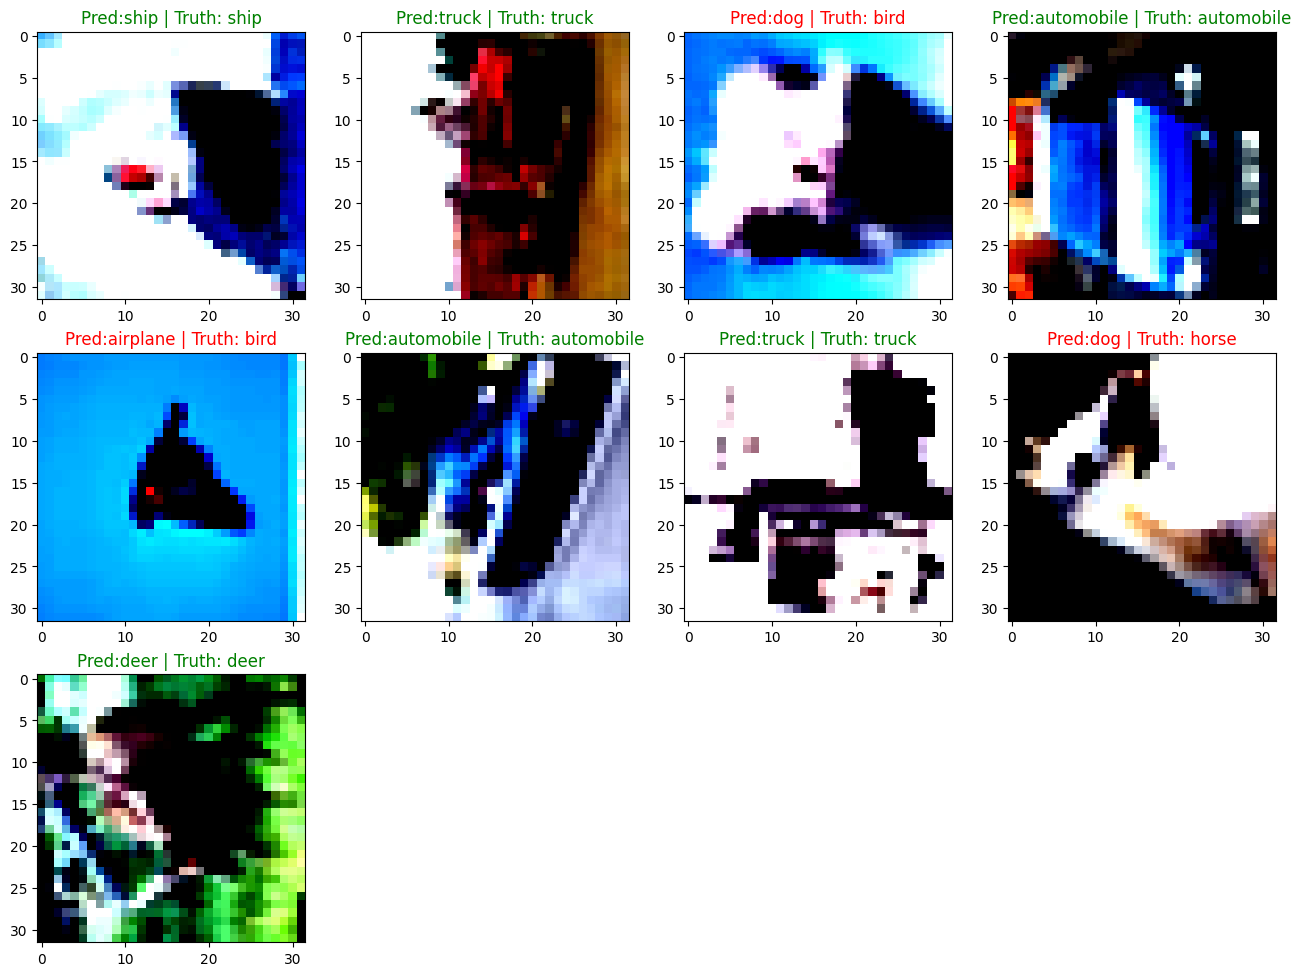

In [ ]:

#Plotting the predictions

plt.figure(figsize=(16,16))

nrows = 4
ncols = 4

for i, sample in enumerate(test_samples):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(sample.permute(2,1,0).squeeze())
    pred_label = updated_test_data.classes[pred_classes[i]]
    truth_label = updated_test_data.classes[test_labels[i]]

    title_text = f"Pred:{pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text,c="g")
    else:
        plt.title(title_text,c="r")

In [395]:
# Confusion Matrix for model prediction evaluation

# 1. Make predictions with our trained model on the test dataset
# 2. Make a confusion matrix torchmetrix.ConfusionMatrix
# 3. Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix()


from tqdm.auto import tqdm
y_preds=[]

model_2.eval()

with torch.inference_mode():
    for X,y in tqdm(updated_test_data_loader,desc="Making predictions...."):
        X,y = X.to(device),y.to(device)

        y_logit = model_2(X)

        y_pred = torch.softmax(y_logit.squeeze(),dim=1).argmax(dim=1)

        y_preds.append(y_pred)

y_preds_tensor = torch.cat(y_preds)       

Making predictions....: 100%|██████████| 313/313 [00:02<00:00, 149.30it/s]


In [ ]:
#Importing necessary packages.
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version:{mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]>=19, "mlxtend version should be 0.19.0 or higher")
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version:0.23.4
mlxtend version: 0.23.4


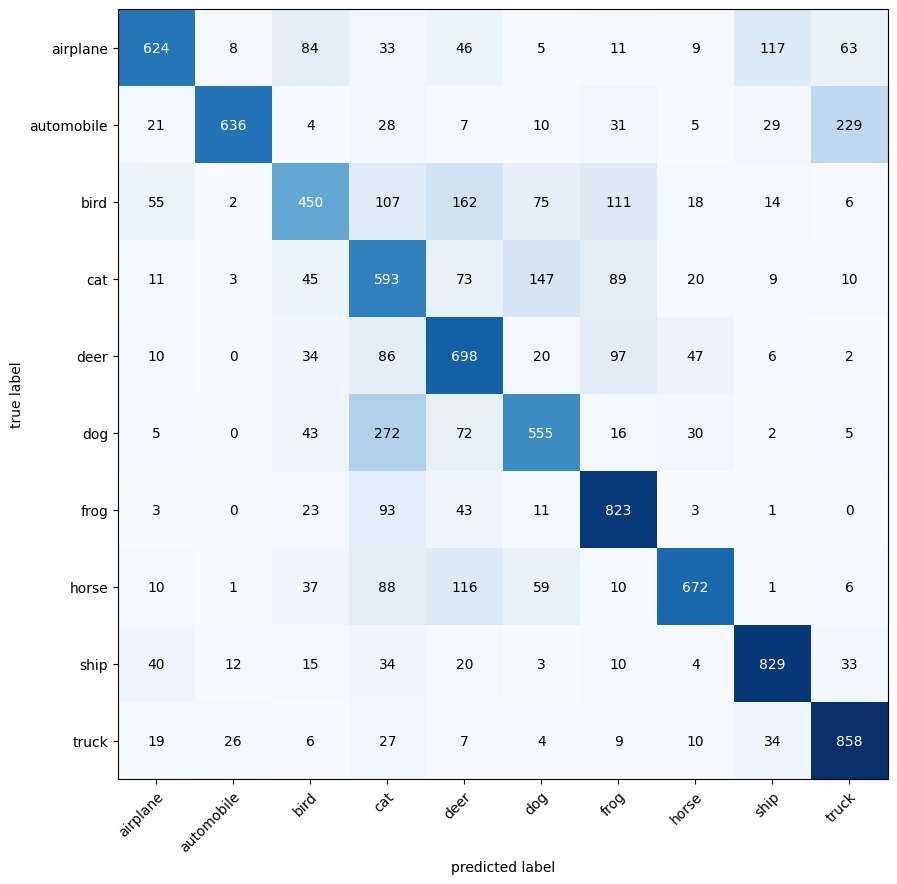

In [ ]:
#Plotting confusion matrix.
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
conf_mat = ConfusionMatrix(task="multiclass",num_classes=len(updated_test_data.classes))
conf_mat_tensor = conf_mat(preds=y_preds_tensor,target=torch.tensor(updated_test_data.targets))
fig,ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(),class_names = updated_test_data.classes,figsize=(10,10))

#It's very evident from the confusion matrix that model got confused between automobile vs truck and dog vs cat. 